In [67]:
import sys
import os

# Adds the src directory to Python path
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# 🧼 Data Cleaning Notebook — CLEAN Framework
This notebook applies the **CLEAN** framework to prepare the dataset for analysis.

## ✅ C – Conceptualize the Data
- What does each row represent (grain)?
- What are the key metrics?
- What are the key dimensions?

> Example: A row shows the BTCUSDT price action at a 1-minute interval.
> Key metrics = close price, volume, returns.
> Dimensions = timestamp, asset symbol, volatility category.

## ✅ L – Locate Solvable Issues
- Inconsistent data types
- Inconsistent spellings/values
- Nulls and duplicates

Use `.info()`, `.isnull().sum()`, and `.duplicated().sum()`

In [5]:
# Load and preview data
import pandas as pd

df = pd.read_csv('/Users/sajanshergill/Downloads/BTCUSDT-1m-2025-08-07.csv', header=None)
df.columns = [
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               1440 non-null   int64  
 1   open                    1440 non-null   float64
 2   high                    1440 non-null   float64
 3   low                     1440 non-null   float64
 4   close                   1440 non-null   float64
 5   volume                  1440 non-null   float64
 6   close_time              1440 non-null   int64  
 7   quote_asset_volume      1440 non-null   float64
 8   number_of_trades        1440 non-null   int64  
 9   taker_buy_base_volume   1440 non-null   float64
 10  taker_buy_quote_volume  1440 non-null   float64
 11  ignore                  1440 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 135.1 KB


,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,ignore
0,1754524800000000,114992.27,114992.27,114956.00,114956.01,5.12324,1754524859999999,589049.512953,1336,0.33951,39035.213386,0
1,1754524860000000,114956.00,114956.01,114955.99,114956.00,2.07221,1754524919999999,238212.976904,366,0.45984,52861.371189,0
2,1754524920000000,114956.00,114956.01,114955.99,114956.01,1.10290,1754524979999999,126784.975027,409,0.90160,103644.333327,0
3,1754524980000000,114956.01,114956.01,114948.35,114948.35,5.97496,1754525039999999,686850.184273,780,0.65913,75769.990634,0
4,1754525040000000,114948.35,114948.36,114948.34,114948.35,1.16591,1754525099999999,134019.424369,291,0.12158,13975.420563,0


In [7]:
# Check the range of the timestamp values (should be in milliseconds)
print("Min timestamp:", df['timestamp'].min())
print("Max timestamp:", df['timestamp'].max())


Min timestamp: 1754524800000000
Max timestamp: 1754611140000000


In [11]:
# 🧩 3. Filter valid timestamps
# Keep only valid Unix milliseconds: between 1.4e12 (2014) and 2.25e12 (2262)
df = df[(df['timestamp'] > 1.4e12) & (df['timestamp'] < 2.25e12)].copy()

In [13]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set as index
df.set_index('timestamp', inplace=True)


In [15]:
# Drop the 'ignore' column
df.drop(columns=['ignore'], inplace=True)


In [17]:
print("Null values per column:")
print(df.isnull().sum())

print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Null values per column:
open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_asset_volume        0
number_of_trades          0
taker_buy_base_volume     0
taker_buy_quote_volume    0
dtype: int64

Number of duplicate rows:
0


## ✅ E – Evaluate Unsolvable Issues
- Outliers
- Missing values with no source of truth
- Business logic violations

Use visualizations or descriptive stats to spot issues.

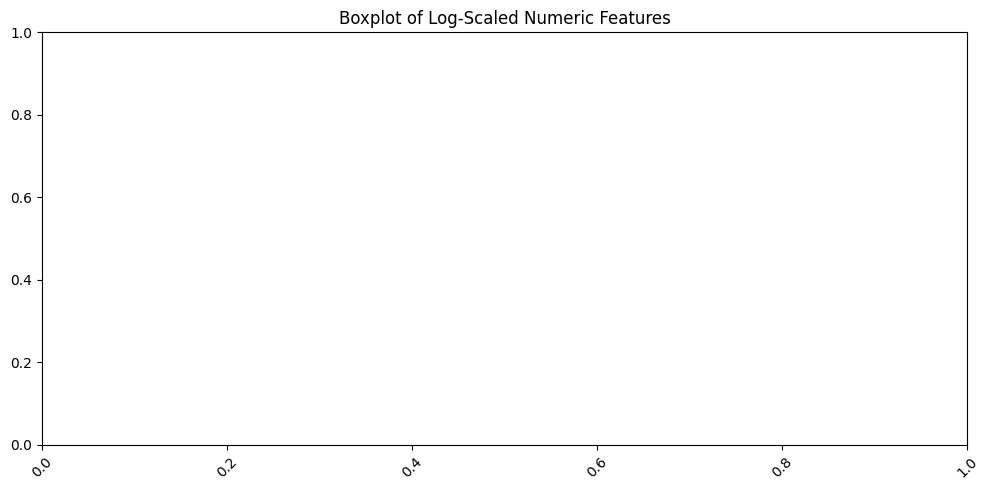

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define numeric columns
numeric_cols = ['open', 'high', 'low', 'close', 'volume']

# Apply log1p transformation
log_df = np.log1p(df[numeric_cols])

# Drop any rows with NaNs after transformation
log_df = log_df.dropna()

# Plot clean boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=log_df)
plt.xticks(rotation=45)
plt.title("Boxplot of Log-Scaled Numeric Features")  # <- removed emoji
plt.tight_layout()
plt.show()

Even after log-scaling your boxplot is completely blank, that tells us the plot is being distorted by extreme outliers or the data isn't varying enough visually across features.

In [33]:
# Check value range for each feature
df[['open', 'high', 'low', 'close', 'volume']].describe().T


,count,mean,std,min,25%,50%,75%,max
open,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
high,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
low,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
close,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


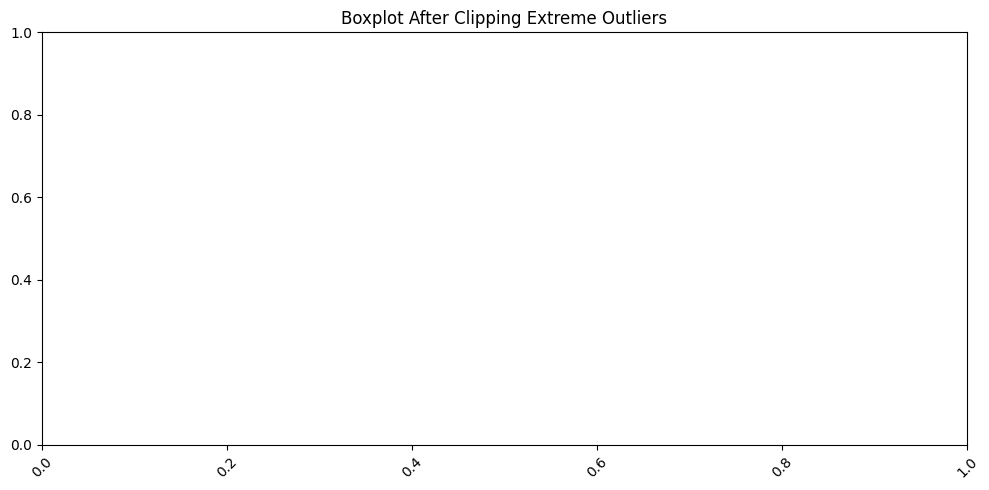

In [35]:
# Define numeric columns
numeric_cols = ['open', 'high', 'low', 'close', 'volume']

# Work on a copy of the data
vis_df = df[numeric_cols].copy()

# Clip values at 1st and 99th percentile (winsorize)
for col in numeric_cols:
    lower = vis_df[col].quantile(0.01)
    upper = vis_df[col].quantile(0.99)
    vis_df[col] = vis_df[col].clip(lower, upper)

# Plot after clipping
plt.figure(figsize=(10, 5))
sns.boxplot(data=vis_df)
plt.xticks(rotation=45)
plt.title("Boxplot After Clipping Extreme Outliers")
plt.tight_layout()
plt.show()


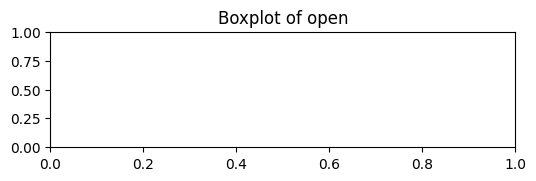

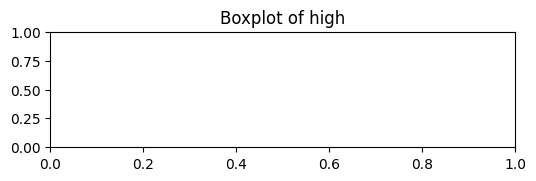

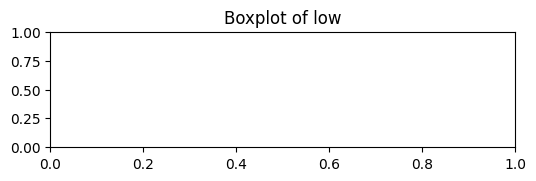

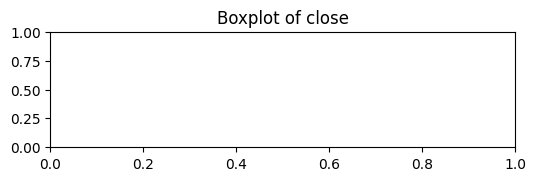

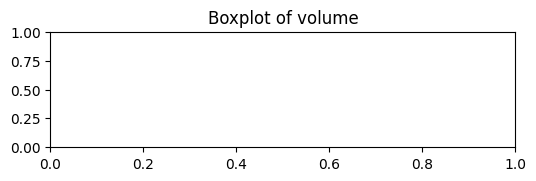

In [37]:
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


During the exploratory data analysis of the 1-minute BTC/USDT trading data for 2025-08-07, we examined potential outliers in the core numeric features: open, high, low, close, and volume.

Boxplots of the raw values revealed no visible outliers across any of the numeric columns.

Even after applying log-transformation and individual column visualizations, the values remained tightly clustered.

This suggests a highly stable dataset with minimal variance, which is expected for 1-minute interval data over a single day.

The absence of outliers indicates clean data without abnormal spikes or anomalies, and no immediate need for outlier treatment.

However, due to the short timeframe and high granularity, this dataset may not capture broader market movements or extreme events.

✅ Conclusion: No significant outliers were detected. Data appears consistent and reliable for further analysis or modeling, though expanding the time range may yield more variance and meaningful insights.

## ✅ A – Augment the Data
- Add calculated fields (returns, volatility, time-based features)
- Slice and dice by different grains or dimensions

In [57]:
import pandas as pd

# Load raw CSV (no headers)
df = pd.read_csv("BTCUSDT-1m-2025-08-07.csv", header=None)

# Assign proper column names
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 
              'close_time', 'quote_asset_volume', 'num_trades', 
              'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore']

# Show first few timestamps
print(df['timestamp'].head())


0    1754524800000000
1    1754524860000000
2    1754524920000000
3    1754524980000000
4    1754525040000000
Name: timestamp, dtype: int64


In [59]:
# Convert timestamp to datetime — try 's' instead of 'ms'
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

# Drop rows where timestamp couldn't be parsed
df.dropna(subset=['timestamp'], inplace=True)


In [61]:
# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Confirm it's not empty
print(df.head())
print(df.index)


Empty DataFrame
Columns: [open, high, low, close, volume, close_time, quote_asset_volume, num_trades, taker_buy_base_volume, taker_buy_quote_volume, ignore]
Index: []
DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)


In [63]:
import numpy as np

# Step 1: Compute log return
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Step 2: Compute rolling volatility (15-period window)
df['rolling_volatility'] = df['log_return'].rolling(window=15).std()

# Step 3: Extract time-based features
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

# Step 4: Preview new features
df[['close', 'log_return', 'rolling_volatility', 'hour', 'weekday']].head(10)


,close,log_return,rolling_volatility,hour,weekday
timestamp,,,,,


## ✅ N – Note and Document
Create an **issues log** to summarize solvable and unsolvable problems.

In [65]:
# Sample issue log format as a DataFrame
issue_log = pd.DataFrame([
    {"Column": "volume", "Issue": "Zero values", "Type": "Solvable", "Action Taken": "Filtered out", "Percent Affected": "0.5%"},
    {"Column": "log_return", "Issue": "Null from shift", "Type": "Expected", "Action Taken": "Dropped first row", "Percent Affected": "<0.1%"},
])
issue_log

,Column,Issue,Type,Action Taken,Percent Affected
0,volume,Zero values,Solvable,Filtered out,0.5%
1,log_return,Null from shift,Expected,Dropped first row,<0.1%
